In [1]:
import numpy as np
import pandas as pd
from db_handler import DBHandler
from matplotlib import pyplot as plt
from scipy import stats
from datetime import datetime, timedelta
from calendar import monthrange
%matplotlib inline

def parse_fetches(fetches):
    _new_fetches = list()
    for _fetch in fetches:
        for _doi in _fetch[0].split(", "):
            _new_fetches.append(
                (_doi, _fetch[1])
            )
    return _new_fetches

def get_dois_with_videos_within_days_from_publish(df, table_name, where=None, days_from=None, days_until=None):
#     複数の動画が与えられる論文の場合、複数のsetに含まれることがある。
    _set_target_dois = set()
    db_handler.sql_handler.select(table_name, ["idx_paper", "publishedAt"])
    if type(where) == tuple:
        db_handler.sql_handler.where(*where)
    fetches = db_handler.execute().fetchall()
    fetches = parse_fetches(fetches)
    
    for _row in fetches:
#         print("DOI:", _row[0])
        _target_paper = df[df["DOI"] == _row[0]]
#         if len(_target_paper) == 0:
#             continue
        if len(_target_paper) > 1:
            _target_paper = _target_paper.iloc[0]
#         print(_target_paper)
        _dt_publish = datetime(_target_paper["Year"], _target_paper["Month"], 1)
        
        if days_from != None:
            _dt_video_from = _dt_publish + timedelta(days=days_from)
            if _row[1] < _dt_video_from:
                continue
        
        if days_until != None:
            _dt_video_until = _dt_publish + timedelta(days=days_until)
            if _row[1] > _dt_video_until:
                continue
        
        _set_target_dois.add(_row[0])
    
#     if days_until == None:
#         _set_target_dois = set(map(lambda _row: _row[0], fetches))
#     else:
#         for _row in fetches:
#             _target_paper = df[df["DOI"] == _row[0]]
#             if len(_target_paper) > 1:
#                 _target_paper = _target_paper.iloc[0]
#             _dt_publish = datetime(_target_paper["Year"], _target_paper["Month"], 1)
            
#             _dt_video_from = _dt_publish + timedelta(days=days_from)
#             _dt_video_until = _dt_publish + timedelta(days=days_until)
            
#             if _row[1] < _dt_video_deadline:
#                 _set_target_dois.add(_row[0])
    
    return _set_target_dois

def plot_area_chart(df, table_name, where=None, days_from=None, days_until=None):
    _db_handler = DBHandler()
    _db_handler.sql_handler.select(table_name, ["idx_paper", "publishedAt"])
    _videos = db_handler.execute().fetchall()
    
    _idx_papers = get_dois_with_videos_within_days_from_publish(df, table_name, where, days_from, days_until)
    
    print("# Total papers: %d\t# papers w/ videos: %d\tRatio: %.3f" % (len(set(df["DOI"])), len(_idx_papers), len(_idx_papers) / len(set(df["DOI"]))))
    
    _subjects_total = df["Scopus Sub-Subject Area"].value_counts()
    _subjects_w_videos = df[df["DOI"].isin(_idx_papers)]["Scopus Sub-Subject Area"].value_counts()
    _subjects_total_w_videos = _subjects_w_videos.reindex(_subjects_total.index, fill_value=0)
    print("# Total subjects: %d\t# subjects w/ videos: %d\tRatio: %.3f" % (len(_subjects_total.index), len(_subjects_w_videos.index), len(_subjects_w_videos.index) / len(_subjects_total.index)))
    
    plt.figure(figsize=(12, 6))
    
    plt.fill_between(
        np.arange(len(_subjects_total)),
        _subjects_total,
        color="skyblue",
        alpha=0.4,
        label='# Papers(Total)'
    )

    plt.bar(
        np.arange(len(_subjects_total_w_videos)),
        _subjects_total_w_videos,
        width=0.4,
        label='# Papers(w/ videos)'
    )
    
#     plt.plot(
#         np.arange(len(_subjects_total)),
#         _subjects_total,
#         color="Slateblue",
#         alpha=0.6,
#         linewidth=2
#     )

#     plt.fill_between(
#         np.arange(len(_subjects_total_w_videos)),
#         _subjects_total_w_videos,
#         color="lightpink",
#         alpha=0.5,
#         label='# Papers(w/ videos)'
#     )

#     plt.plot(
#         np.arange(len(_subjects_total_w_videos)),
#         _subjects_total_w_videos,
#         color="pink",
#         alpha=0.6,
#         linewidth=2
#     )

    plt.tick_params(labelsize=12)
    plt.xticks(np.arange(len(_subjects_total)), _subjects_total.index, rotation=90)
    plt.xlabel('Sub-Subject', size=12)
    plt.ylabel('Count', size=12)
    plt.yscale("log")
    # plt.ylim(bottom=0)
#     plt.legend(labels=['# Papers(Total)', '# Papers(w/ videos)'])
    plt.legend()

    plt.show()

In [113]:
from scopus_handler import ScopusHandler

In [4]:
df1 = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_math+comp_top5perc_1901-1906.csv")
# df2 = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_math+comp_top5perc_1701-1706.csv")
df3 = pd.read_csv("/home/hweem/git/mastersdegree/ytcrawl/customs/scopus/scopus_math+comp_top5perc_1401-1406.csv")

In [3]:
_idx_papers_2014 = get_dois_with_videos_within_days_from_publish(df3, "scopus_videos_2014_comp")

print(
    len(_idx_papers_2019),
#     len(_idx_papers_2019_exp),
#     len(_idx_papers_2019_news),
#     len(_idx_papers_2019_sup),
#     len(_idx_papers_2019_ref),
    len(_idx_papers_2014),
#     len(_idx_papers_2014_exp),
#     len(_idx_papers_2014_news),
#     len(_idx_papers_2014_sup),
#     len(_idx_papers_2014_ref)
)
print(
    "2019 ratio of papers w/ videos: %.2f" % (100 * len(_idx_papers_2019) / len(set(df1["DOI"]))),
    "2014 ratio of papers w/ videos: %.2f" % (100 * len(_idx_papers_2014) / len(set(df3["DOI"])))
)

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`;


NameError: name '_idx_papers_2019' is not defined

In [ ]:
print(
    len(set(df3[df3["DOI"].isin(_idx_papers_2014)]["Scopus Sub-Subject Area"])),
    len(set(df3["Scopus Sub-Subject Area"]))
)

In [63]:
subjects_total = df3["Scopus Sub-Subject Area"].value_counts()

In [23]:
subjects_w_videos = df3[df3["DOI"].isin(_idx_papers_2014)]["Scopus Sub-Subject Area"].value_counts()

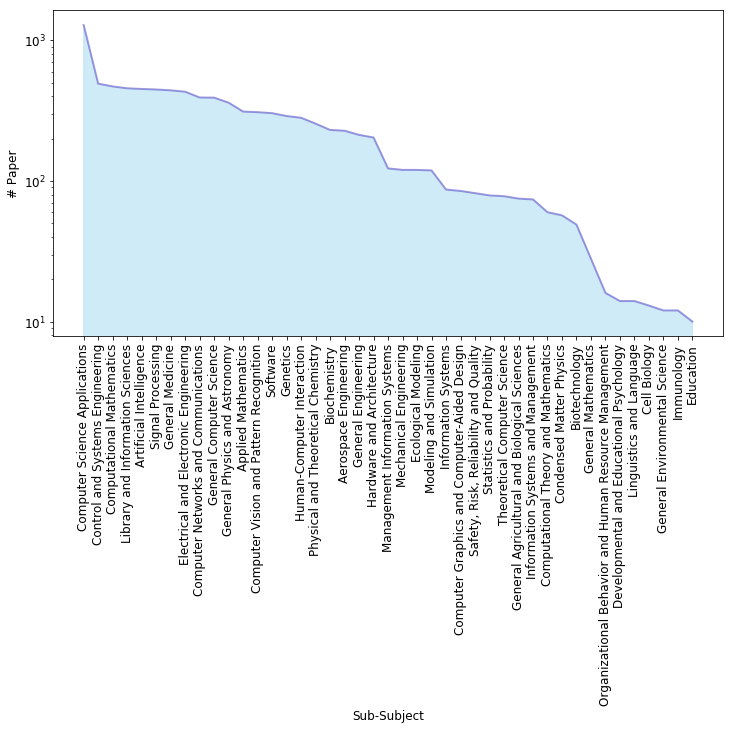

In [30]:
plt.figure(figsize=(12, 6))
plt.fill_between(
    np.arange(len(subjects_total)),
    subjects_total,
    color="skyblue",
    alpha=0.4
)
plt.plot(
    np.arange(len(subjects_total)),
    subjects_total,
    color="Slateblue",
    alpha=0.6,
    linewidth=2
)

plt.tick_params(labelsize=12)
plt.xticks(np.arange(len(subjects_total)), subjects_total.index, rotation=90)
plt.xlabel('Sub-Subject', size=12)
plt.ylabel('# Paper', size=12)
plt.yscale("log")
# plt.ylim(bottom=0)

plt.show()

In [38]:
# subjects_total.index
# pd.Series(0, index=subjects_total.index)
# pd.Series(0, index=subjects_total.index).combine(subjects_w_videos, func=max)
subjects_total_w_videos = subjects_w_videos.reindex(subjects_total.index, fill_value=0)

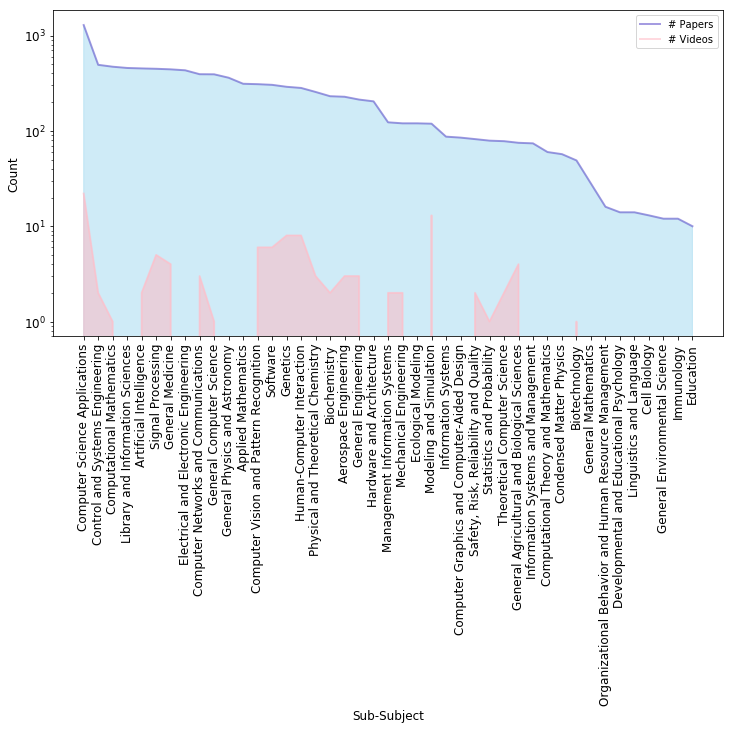

In [50]:
plt.figure(figsize=(12, 6))
plt.fill_between(
    np.arange(len(subjects_total)),
    subjects_total,
    color="skyblue",
    alpha=0.4,
    label='# Papers'
)

plt.plot(
    np.arange(len(subjects_total)),
    subjects_total,
    color="Slateblue",
    alpha=0.6,
    linewidth=2
)

plt.fill_between(
    np.arange(len(subjects_total_w_videos)),
    subjects_total_w_videos,
    color="lightpink",
    alpha=0.5,
    label='# Videos'
)

plt.plot(
    np.arange(len(subjects_total_w_videos)),
    subjects_total_w_videos,
    color="pink",
    alpha=0.6,
    linewidth=2
)


plt.tick_params(labelsize=12)
plt.xticks(np.arange(len(subjects_total)), subjects_total.index, rotation=90)
plt.xlabel('Sub-Subject', size=12)
plt.ylabel('Count', size=12)
plt.yscale("log")
# plt.ylim(bottom=0)
plt.legend(labels=["# Papers", "# Videos"])

plt.show()

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`;
	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`;
# Total papers: 9336	# papers w/ videos: 102	Ratio: 0.011
# Total subjects: 43	# subjects w/ videos: 24	Ratio: 0.558


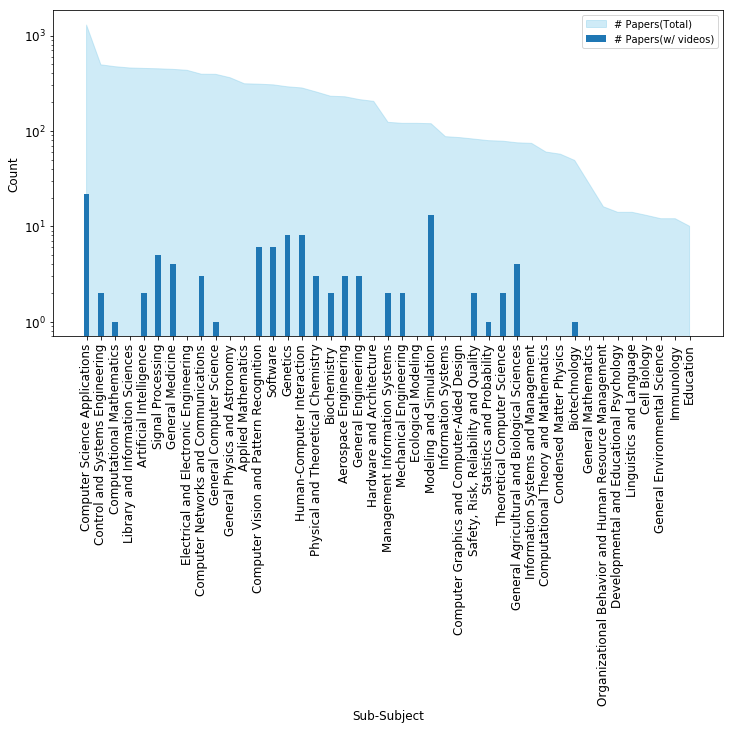

In [107]:
plot_area_chart(df3, "scopus_videos_2014_comp")

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`;
	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`;
# Total papers: 14330	# papers w/ videos: 64	Ratio: 0.004
# Total subjects: 46	# subjects w/ videos: 22	Ratio: 0.478


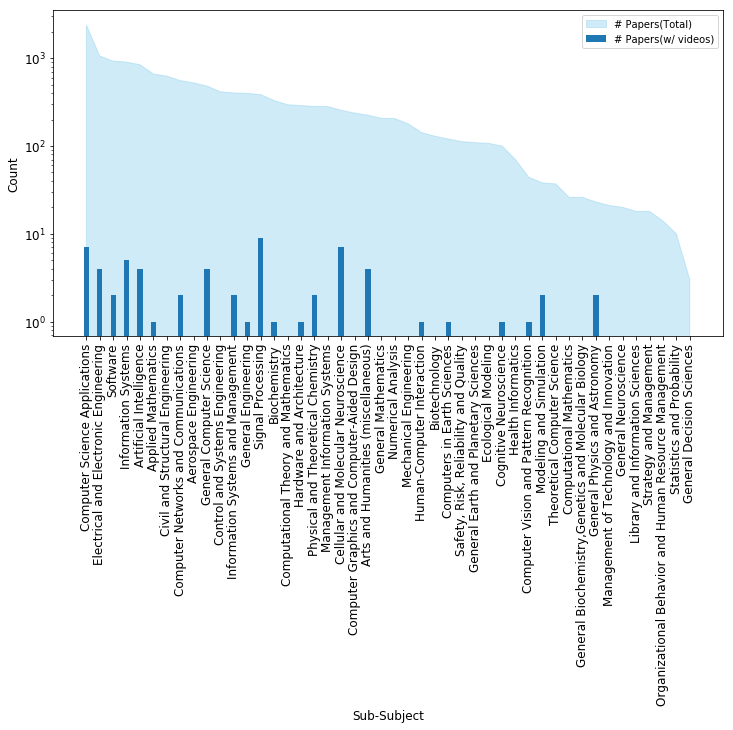

In [108]:
plot_area_chart(df1, "scopus_videos_2019_comp")

연도에 따른 비디오 커뮤니케이션의 활성도 비교: 비디오 공개시기를 1년으로 지정

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`;
	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`;
# Total papers: 9336	# papers w/ videos: 67	Ratio: 0.007
# Total subjects: 43	# subjects w/ videos: 18	Ratio: 0.419


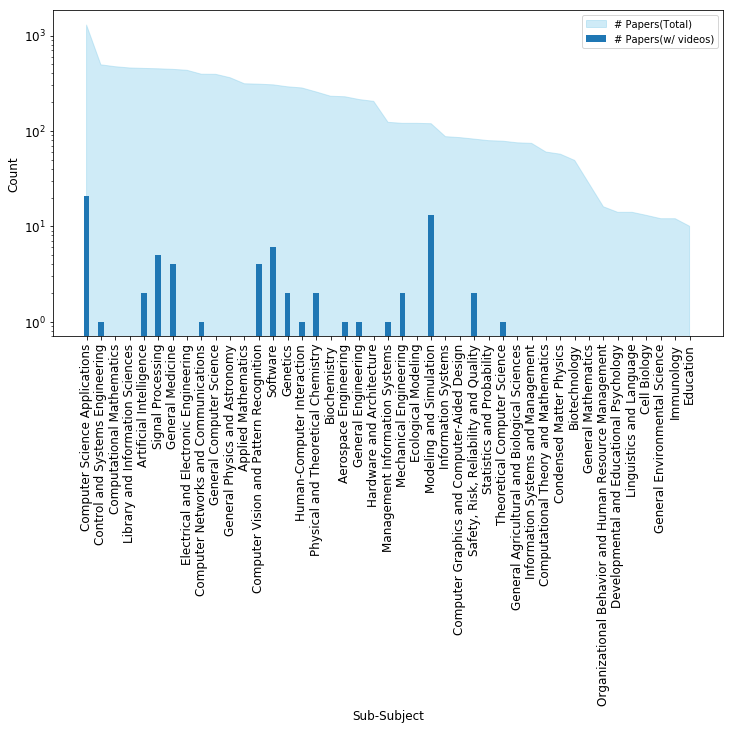

In [109]:
plot_area_chart(df3, "scopus_videos_2014_comp", days_until=360)

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`;
	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`;
# Total papers: 14330	# papers w/ videos: 50	Ratio: 0.003
# Total subjects: 46	# subjects w/ videos: 20	Ratio: 0.435


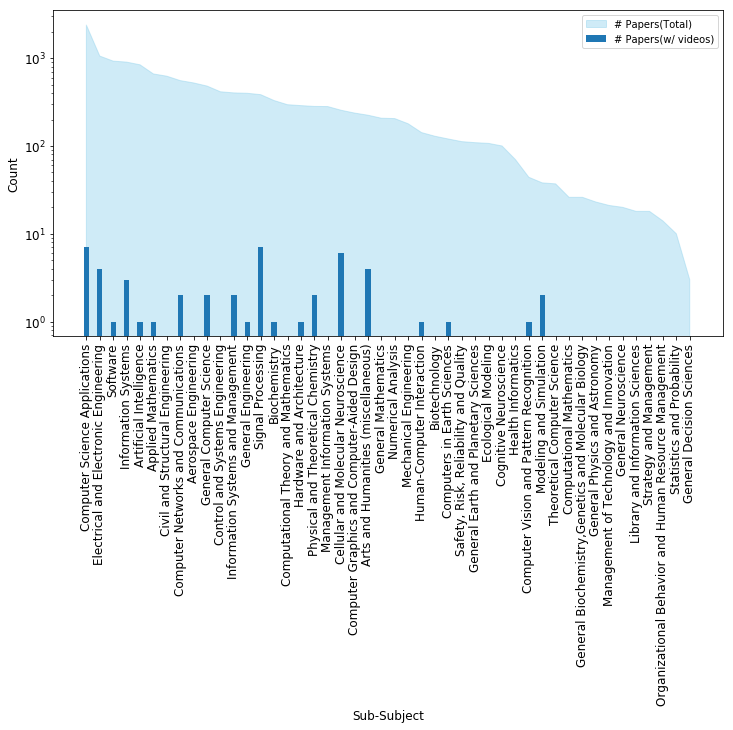

In [110]:
plot_area_chart(df1, "scopus_videos_2019_comp", days_until=360)

논문 게재 후 1년 이내의 비디오를 조사해보면, 전체 논문에 대한 비디오 있는 논문의 비율은 반감 (0.007->0.003). 다만 비디오 있는 논문의 절대적인 수는 큰 변화 없음(67->50). 원인으로는 1.학술활동이 급격히 증가에 비해(전체 논문 수:9336->14330) 비디오 커뮤니케이션에 대한 주목도는 변화하지 않음 2.비디오 커뮤니케이션의 활성도가 저하(0.007->0.003)

비디오 커뮤니케이션에 관한 관심이나 붐은 목격되지 않았으니 1이 더 타당하다?

더욱 초창기 비디오(90)로 좁히면?

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`;
	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`;
# Total papers: 9336	# papers w/ videos: 25	Ratio: 0.003
# Total subjects: 43	# subjects w/ videos: 9	Ratio: 0.209


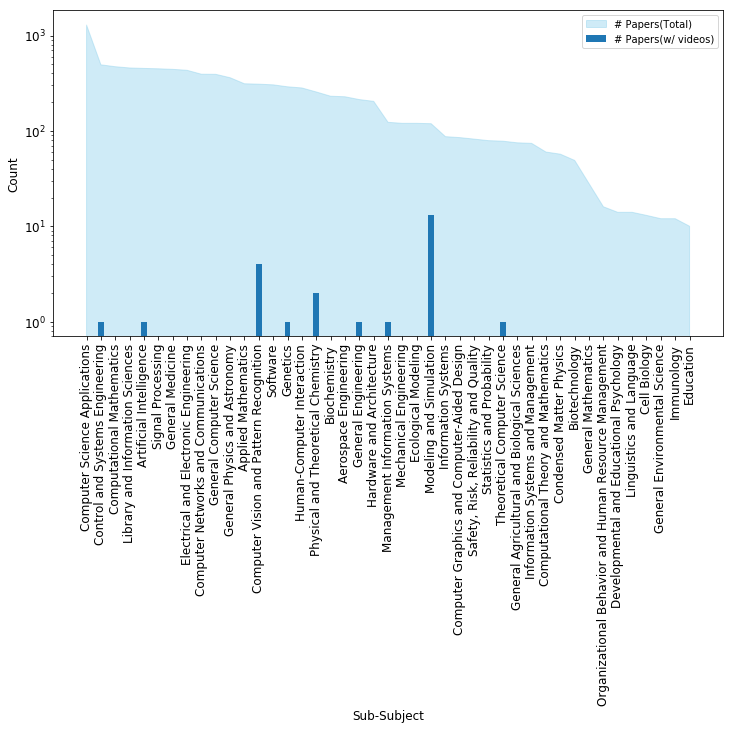

In [111]:
plot_area_chart(df3, "scopus_videos_2014_comp", days_until=90)

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`;
	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`;
# Total papers: 14330	# papers w/ videos: 36	Ratio: 0.003
# Total subjects: 46	# subjects w/ videos: 17	Ratio: 0.370


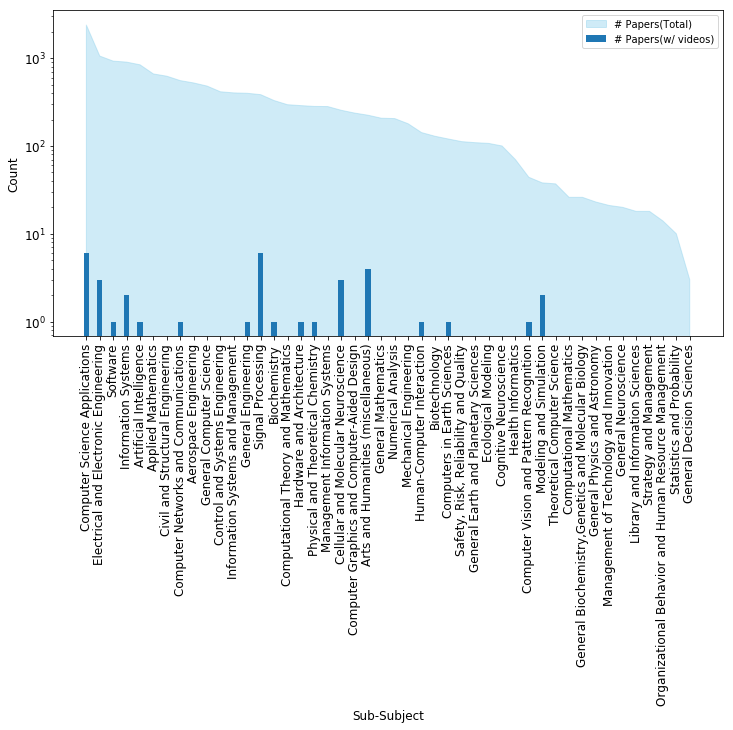

In [112]:
plot_area_chart(df1, "scopus_videos_2019_comp", days_until=90)

90일 이내의 경우 비율이 같다(0.003->0.003) -> 논문 게재 초창기에 대해선 비디오 커뮤니케이션의 활성도가 비슷하다.

특이한 점은 1. 메인 소분야(왼쪽)에 대한 활성도가 2014년엔 미미했으나 2019년엔 높다.

각 소분야마다 비디오 논문 비율 확인

In [5]:
from scopus_handler import ScopusHandler
scopus_handler_2014 = ScopusHandler(df3, "scopus_videos_2014_comp")

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`;
	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2014_comp`;
# Total papers: 9336	# papers w/ videos: 67	Ratio: 0.007
# Total subjects: 43	# subjects w/ videos: 18	Ratio: 0.419


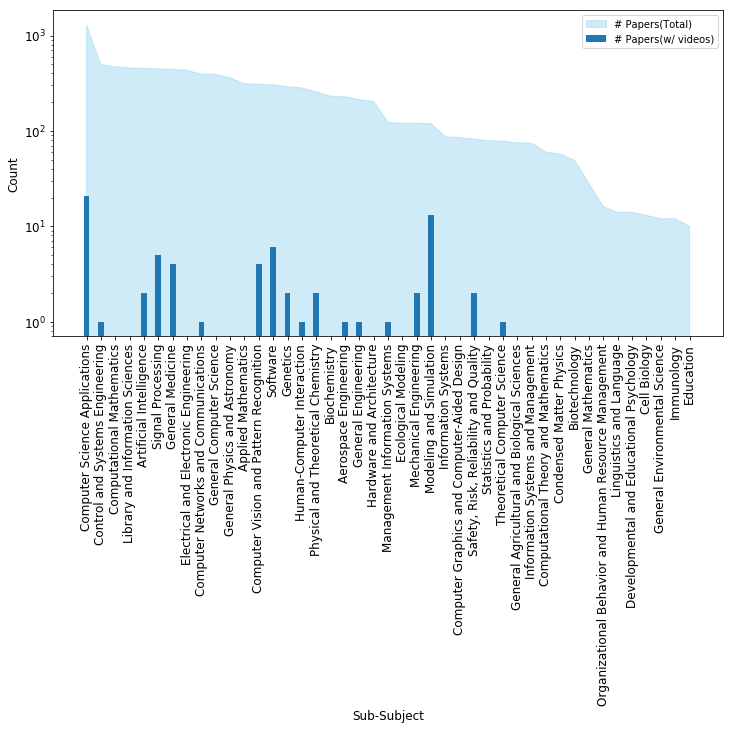

In [11]:
scopus_handler_2014.plot_area_chart(days_until=360)

In [41]:
s_2014_360 = scopus_handler_2014.subjects_total_w_videos / scopus_handler_2014.subjects_total

In [42]:
scopus_handler_2019 = ScopusHandler(df1, "scopus_videos_2019_comp")

In [43]:
scopus_handler_2019.set_idx_papers(days_until=360)

	Command set: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`
	sql: SELECT `idx_paper`, `publishedAt` FROM `scopus_videos_2019_comp`;
# Total papers: 14330	# papers w/ videos: 50	Ratio: 0.003
# Total subjects: 46	# subjects w/ videos: 20	Ratio: 0.435


In [44]:
s_2019_360 = scopus_handler_2019.subjects_total_w_videos / scopus_handler_2019.subjects_total
s_2019_360

Computer Science Applications                            0.002942
Electrical and Electronic Engineering                    0.003788
Software                                                 0.001081
Information Systems                                      0.003330
Artificial Intelligence                                  0.001190
Applied Mathematics                                      0.001513
Civil and Structural Engineering                         0.000000
Computer Networks and Communications                     0.003604
Aerospace Engineering                                    0.000000
General Computer Science                                 0.004158
Control and Systems Engineering                          0.000000
Information Systems and Management                       0.004975
General Engineering                                      0.002513
Signal Processing                                        0.018229
Biochemistry                                             0.003040
Computatio

In [48]:
df_ratio_360 = pd.DataFrame([s_2014_360, s_2019_360], index=["2014", "2019"]).T
df_ratio_360

,2014,2019
Computer Science Applications,0.016317,0.002942
Control and Systems Engineering,0.002028,0.000000
Computational Mathematics,0.000000,0.000000
Library and Information Sciences,0.000000,0.000000
Artificial Intelligence,0.004425,0.001190
Signal Processing,0.011161,0.018229
General Medicine,0.009050,NaN
Electrical and Electronic Engineering,0.000000,0.003788
Computer Networks and Communications,0.002545,0.003604
General Computer Science,0.000000,0.004158


In [49]:
df_ratio_360_0 = df_ratio_360.dropna()
df_ratio_360_0["increment"] = df_ratio_360_0["2019"] - df_ratio_360_0["2014"]
df_ratio_360_0.sort_values(by=["increment"], ascending=False)

/home/hweem/git/mastersdegree/ytcrawl/ytcrawl0/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,2014,2019,increment
Computer Vision and Pattern Recognition,0.012945,0.022727,0.009782
Signal Processing,0.011161,0.018229,0.007068
Information Systems and Management,0.000000,0.004975,0.004975
General Computer Science,0.000000,0.004158,0.004158
Electrical and Electronic Engineering,0.000000,0.003788,0.003788
Human-Computer Interaction,0.003546,0.007042,0.003496
Hardware and Architecture,0.000000,0.003472,0.003472
Information Systems,0.000000,0.003330,0.003330
Biochemistry,0.000000,0.003040,0.003040
Applied Mathematics,0.000000,0.001513,0.001513


소분야별 360일 내 비디오 공개 논문 비율 분석 결과, Computer Vision and Pattern Recognition가 가장 크게 증가 -> 2014 이후로 머신러닝 붐 효과로 보임 ->그래봤자 논문 1개... 샘플이 너무 적어서 할말이 없네...

In [53]:
df_count_360 = pd.DataFrame([scopus_handler_2014.subjects_total_w_videos, scopus_handler_2019.subjects_total_w_videos], index=["2014", "2019"]).T.dropna()
df_count_360["increment"] = df_count_360["2019"] - df_count_360["2014"]
df_count_360.sort_values(by=["increment"], ascending=False)

,2014,2019,increment
Electrical and Electronic Engineering,0.0,4.0,4.0
Information Systems,0.0,3.0,3.0
Signal Processing,5.0,7.0,2.0
General Computer Science,0.0,2.0,2.0
Information Systems and Management,0.0,2.0,2.0
Hardware and Architecture,0.0,1.0,1.0
Computer Networks and Communications,1.0,2.0,1.0
Applied Mathematics,0.0,1.0,1.0
Biochemistry,0.0,1.0,1.0
Organizational Behavior and Human Resource Management,0.0,0.0,0.0


Computer Vision and Pattern Recognition같은 경우 오히려 비디오 논문 개수는 감소(4->1). 다만 게재 논문 수도 크게 줄었기 때문에 비율상 더 높아진 것일 뿐.

혹시 content별로 분석하면? 예를 들어 content별로 집중되는 분야같은게 있나?